Cardiovascular diseases are the leading cause of death worldwide.
Heart failure represents a complex clinical syndrome with high mortality rates despite medical advances.

The objective of this project is to explore clinical predictors associated with mortality in heart failure patients and to evaluate the potential of machine learning models as decision-support tools, emphasizing interpretability, fairness, and clinical plausibility.

Source: Kaggle – Heart Failure Clinical Records

N = 299 patients

Outcome: DEATH_EVENT

Study type: observational, retrospective

In [1]:
# Environment setup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

RANDOM_STATE = 42
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("/workspaces/Heart-disease-prediction/heart_failure_clinical_records_dataset.csv")

df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [3]:
df.isna().sum()
df.duplicated().sum()

np.int64(0)

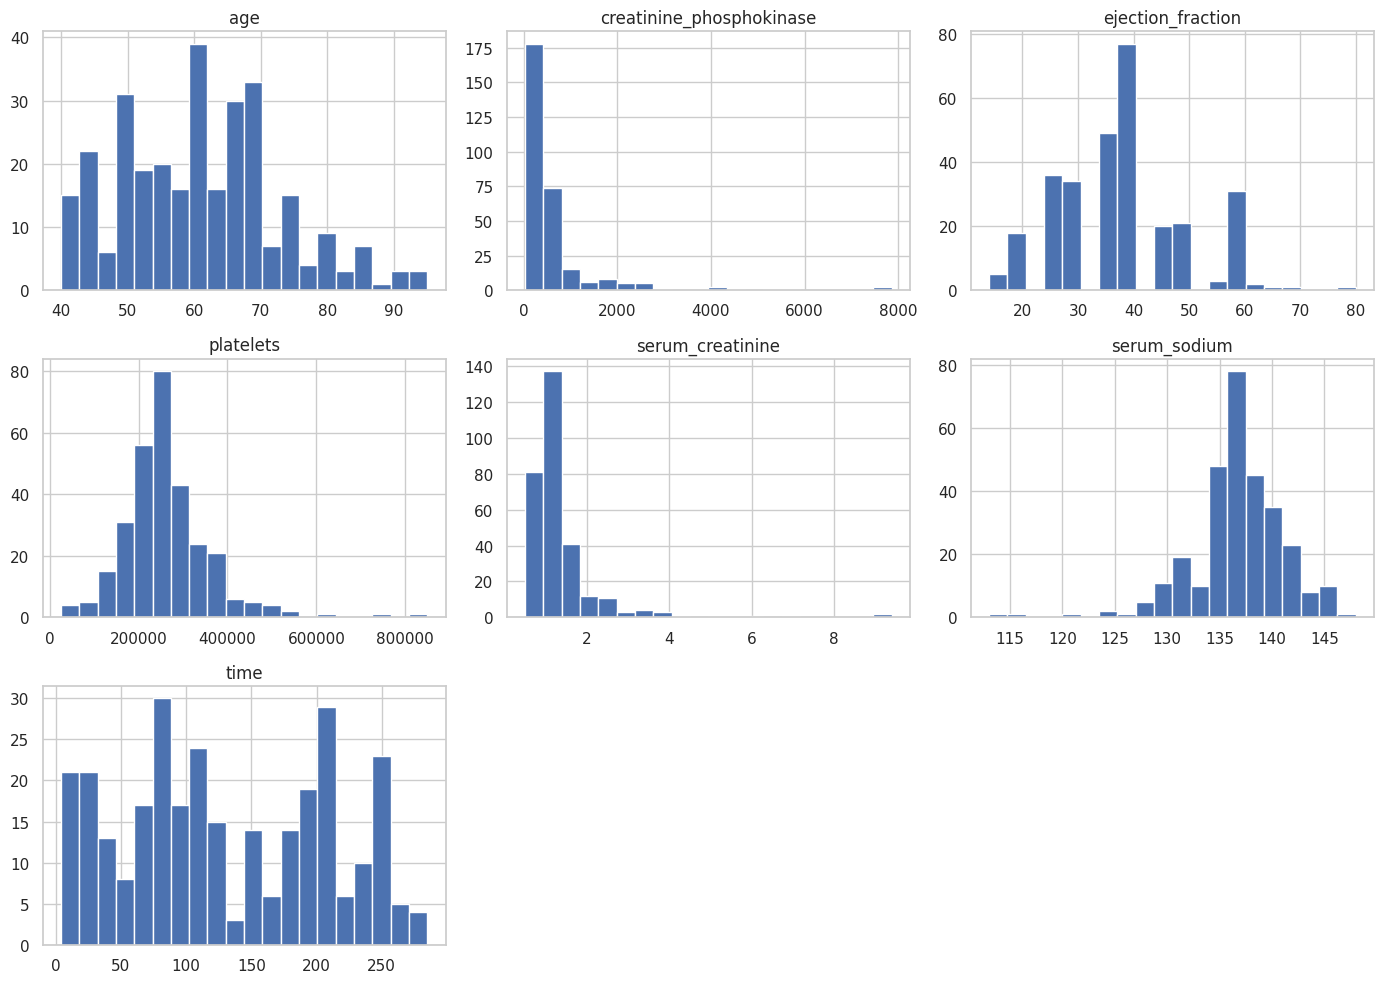

In [4]:
# Dataset is clean
# Analysis of numeric variables

num_cols = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time"
]

df[num_cols].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

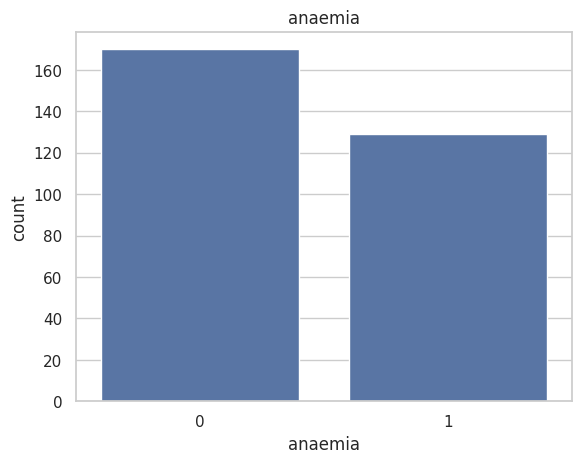

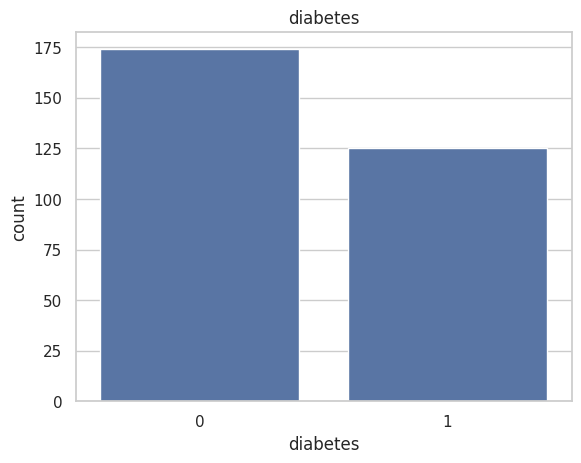

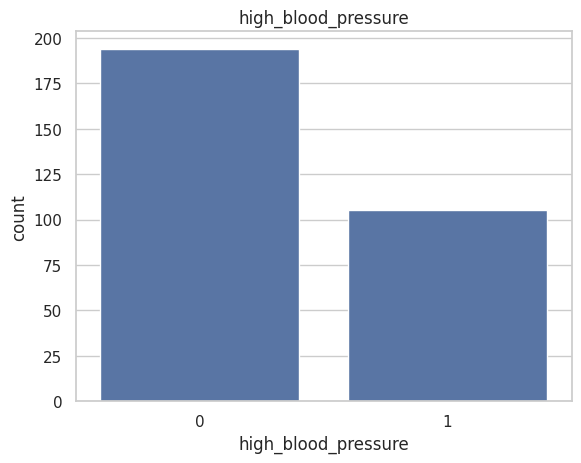

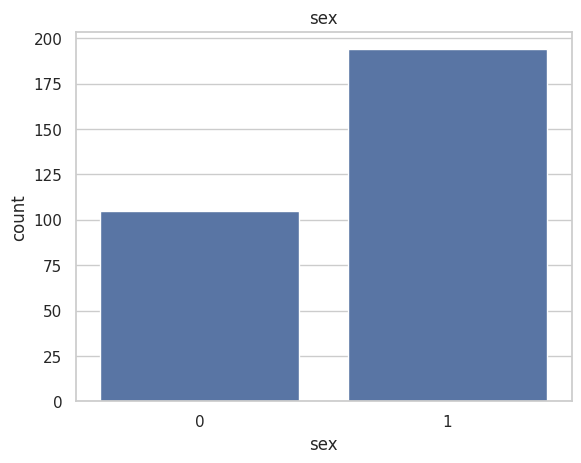

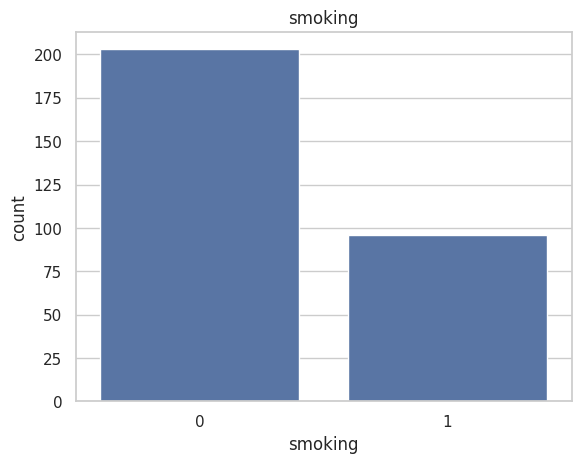

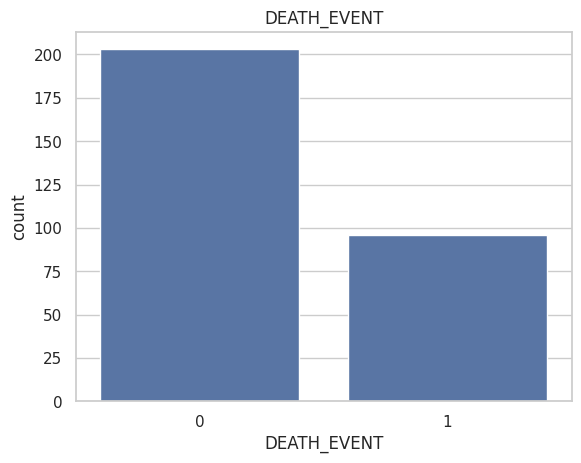

In [5]:
# Analysis of binary variables

bin_cols = [
    "anaemia", "diabetes", "high_blood_pressure",
    "sex", "smoking", "DEATH_EVENT"
]

for col in bin_cols:
    sns.countplot(x=col, data=df)
    plt.title(col)
    plt.show()

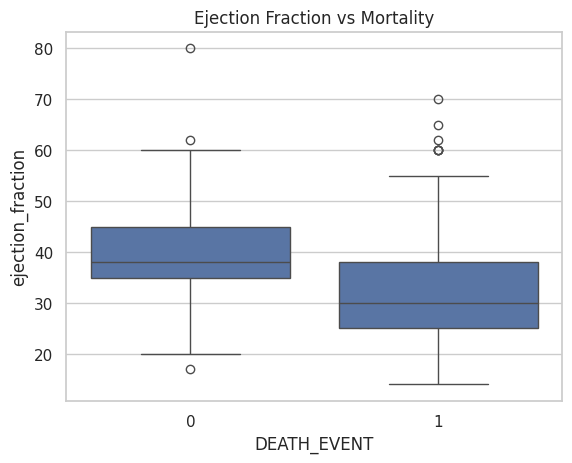

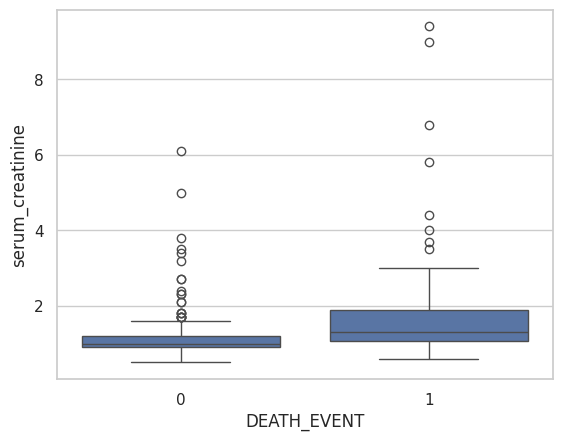

In [6]:
# Bivariate analysis with mortality
# Hypothesis:
# Decreased ejection fraction → greater mortality
# Increased serum creatinine → Worst prognosis

sns.boxplot(x="DEATH_EVENT", y="ejection_fraction", data=df)
plt.title("Ejection Fraction vs Mortality")
plt.show()

sns.boxplot(x="DEATH_EVENT", y="serum_creatinine", data=df)
plt.show()

Predictive Modeling:

* Logistic Regression (clinical baseline)

* Random Forest (non-linear model)

Logistic regression offers interpretability, while Random Forest captures non-linear interactions.

In [7]:
# Data preparation

X = df.drop("DEATH_EVENT", axis=1)
y = df["DEATH_EVENT"]

numeric_features = [
    "age", "creatinine_phosphokinase", "ejection_fraction",
    "platelets", "serum_creatinine", "serum_sodium", "time"
]

binary_features = [
    "anaemia", "diabetes", "high_blood_pressure",
    "sex", "smoking"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features)
    ]
)

In [8]:
# T tests to compare means

dead = df[df["DEATH_EVENT"] == 1]["ejection_fraction"]
alive = df[df["DEATH_EVENT"] == 0]["ejection_fraction"]

stats.ttest_ind(dead, alive, equal_var=False)

TtestResult(statistic=np.float64(-4.56698316342773), pvalue=np.float64(9.647152798521775e-06), df=np.float64(164.7609594812801))

In [9]:
# There are statistically significant differences between the means

def cohens_d(a, b):
    return (a.mean() - b.mean()) / np.sqrt(
        ((a.std() ** 2) + (b.std() ** 2)) / 2
    )

cohens_d(dead, alive)

np.float64(-0.5798599481944705)

In [10]:
# The Cohen's d effect size.

# Cohen's d is a standardized effect size measure indicating the magnitude of difference
# between two group means, expressed in standard deviation units.

# If Cohen's d is 0.5 (similar to this case), the two group means differ by half a
# standard deviation, indicating a moderate effect size.

In [11]:
table = pd.crosstab(df["diabetes"], df["DEATH_EVENT"])
stats.chi2_contingency(table)

Chi2ContingencyResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), dof=1, expected_freq=array([[118.13377926,  55.86622074],
       [ 84.86622074,  40.13377926]]))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [13]:
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('bin', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [14]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_proba)

              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



0.8613607188703467

In [15]:
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE
    ))
])

rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('bin', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [16]:
importances = rf.named_steps["model"].feature_importances_
features = rf.named_steps["preprocessor"].get_feature_names_out()

pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

,feature,importance
6,num__time,0.357255
4,num__serum_creatinine,0.150480
2,num__ejection_fraction,0.129399
0,num__age,0.078757
3,num__platelets,0.076121
1,num__creatinine_phosphokinase,0.075464
5,num__serum_sodium,0.066993
7,bin__anaemia,0.015154
9,bin__high_blood_pressure,0.014338
11,bin__smoking,0.012659


In [17]:
test_df = X_test.copy()
test_df["true"] = y_test
test_df["pred"] = rf.predict(X_test)

pd.crosstab(test_df["sex"], test_df["pred"], normalize="index")

pred,0,1
sex,,
0,0.684211,0.315789
1,0.780488,0.219512


Model performance was evaluated across sex groups.
While predictive behavior appeared broadly consistent, the limited sample size prevents robust fairness conclusions.
Clinical deployment would require external validation and subgroup-specific calibration.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
(60, 12)
(60, 12)


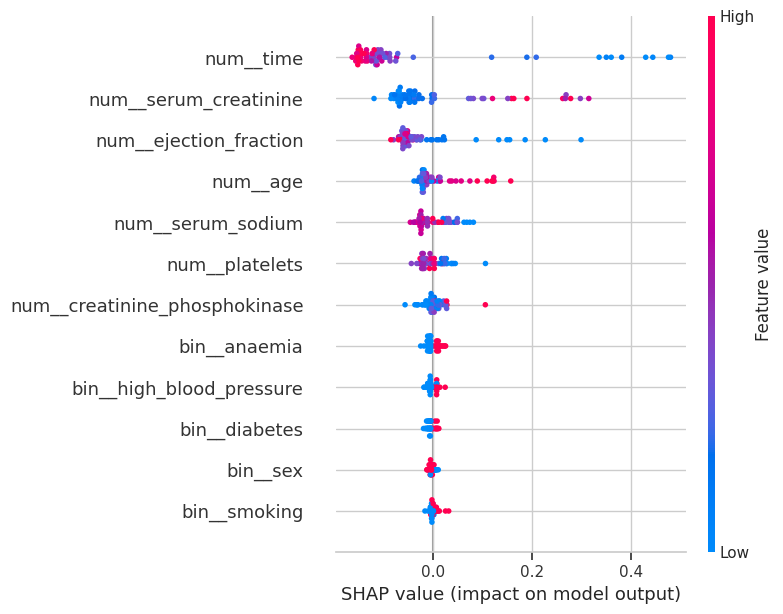

In [25]:
%pip install "numpy<2.3" --quiet
%pip install shap --quiet
import shap
import numpy as np
from tqdm.notebook import tqdm

# Preprocessing test data

preprocessor_fitted = rf.named_steps["preprocessor"]
rf_model = rf.named_steps["model"]
X_test_proc = preprocessor_fitted.transform(X_test)
feature_names = preprocessor_fitted.get_feature_names_out()

explainer = shap.TreeExplainer(rf_model)
shap_exp = explainer(X_test_proc)

shap_values_pos = shap_exp.values[:, :, 1]

print(shap_values_pos.shape)
print(X_test_proc.shape)

shap.summary_plot(
    shap_values_pos,
    X_test_proc,
    feature_names=feature_names
)

In [26]:
# SHAP shows:

# Y axis: variables, ordered by global importance (average absolute value)
# X axis: SHAP value (impact on model output). Positive SHAP values increase the likelihood of mortality.

# Color:

# 🔵 Blue → low values of the variable
# 🔴 Red → high values of the variable

SHAP analysis highlights ejection fraction and serum creatinine as the most influential predictors of mortality.

Lower ejection fraction values contribute positively to mortality risk, consistent with reduced cardiac output and advanced heart failure severity.

Elevated serum creatinine reflects impaired renal function, reinforcing the well-known cardio–renal syndrome, a major determinant of poor prognosis in heart failure patients.

The variable time shows strong predictive importance; however, it reflects follow-up duration rather than a physiological parameter and may introduce temporal leakage, limiting its use in real-time clinical decision-making.

Clinical Interpretation

1. Serum creatinine reflects impaired renal function, consistent with cardiorenal syndrome.
One of the most robust prognostic predictors in heart failure.

2. Ejection fraction, lower ejection fraction = lower cardiac output.
Classic indicator of heart failure severity.

3. Advanced age = reduced physiological reserve, Higher burden of comorbidities.

4. Serum sodium, hyponatremia is a negative prognostic marker in heart failure. Associated with neurohormonal activation.

Platelets. Lower weight is a direct predictor of the disease. This may reflect an inflammatory state or comorbidities, but it is not a determining factor.

Creatinine phosphokinase. Elevated levels may reflect muscle damage or stress. It is not a specific or stable marker of mortality.

Binary variables (anaemia, hypertension, diabetes, sex, smoking). These are risk factors, but: they do not determine immediate mortality. Their effect is usually mediated by organ damage (kidney, heart).

Model interpretability using SHAP revealed that mortality prediction is primarily driven by indicators of disease severity and organ dysfunction, including reduced ejection fraction, impaired renal function, electrolyte imbalance, and age.

These findings are clinically consistent with established prognostic factors in heart failure, reinforcing the medical plausibility of the model.

Although follow-up time emerged as the most influential feature, it reflects survival duration rather than a baseline clinical variable and should be cautiously interpreted in predictive applications.